## 02 - Data Cleaning and Exploration 

This notebook will perform basic QA/QC checks on the fish data I extracted. 

Notebooks objectives 
- Remove unusable records (e.g. no coordinates/dates)
- Visualise the spatial distribution of samples using a map
- Visualise the temporal spread of data points
- Check on study size of key fields ( 'family' , 'sex' , 'lifestage')

#### Step 1. Load in dataset. #####

I'm sourcing the cleaned OBIS data that I extracted in the previous file 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

df = pd.read_csv("data/data_interim/raw_obis_fish_occurences.csv")

# I Print a message to let myself know its loaded in correctly should be 100k records and all the columns specified prior #
print(f"Loaded {df.shape[0]} records and {df.shape[1]} columns")

Loaded 100000 records and 12 columns


#### Step 2. Cleaning : look for and deal with missing/incomplete records ####

The OBIS data is an amalgamtion of various surveys / databses. Whats common when working with such (Meta) databases is that you will have records which hold different attributes as each survey is usually completed with different objectives. 
The minimum requirement I'm interested in is temporal and spatial reference points. Without them they have no use in a study looking at spatial distribution or timeseries investigations. 
SO......
- Ensure all records have valid Lat Longs
- Ensure all records have a date stamp


In [2]:
## Removing records without lat longs

df = df.dropna(subset=["decimalLatitude", "decimalLongitude", "eventDate"])

## QC check. I'm going to question how many records sit either in_box = inside survey, or out_of_box = outside study area
# First stage for this is to redefine the max and min lats and longs

min_lat, max_lat = 36.0, 48.0   
min_lon, max_lon = -10.0, -1.0  

# Describe in_box rows using the above coordinates

in_box = (
    df['decimalLatitude'].between(min_lat, max_lat)
    & df['decimalLongitude'].between(min_lon, max_lon)
)

## I'll get the code to print out some totals to inspect. hint there should be no Out-of-box

print("Total rows:", len(df))
print("In-box rows:", in_box.sum())
print("Out-of-box rows:", (~in_box).sum())

## I'm now sure all my records are in survey area. 

## I'll now remove records without a date associated. To do this first ensure that the date column is in correct format.
# this caused me a bit of a headache, its why sometimes you need to look at the raw data. some records have time included in date 
# all time stamps are preceded by a T so I will use this to my advantage. 

# I can simply remove time, anything after 'T'
strip_time = df['eventDate'].astype(str).str.strip().str.split('T', n=1).str[0]

# Normalize separators to '-' (handles 01/05/2004 type dates)
strip_time = strip_time.str.replace('/', '-', regex=False)

# Reformat my date columns to day first. This also correctly handles YYYY-MM-DD.
day_first = pd.to_datetime(strip_time, errors='coerce', dayfirst=True)

# Keep only rows with a valid date
keep = day_first.notna()
dropped = (~keep).sum()
print(f"Dropping {dropped} rows with no parsable date.")

df = df[keep].copy()

# Store back as string in the format dd-mm-yyyy
df['eventDate'] = day_first.loc[keep].dt.strftime('%d-%m-%Y')

# Now I want to enforce my study period 
start = pd.to_datetime('01-01-1990', dayfirst=True)
end   = pd.to_datetime('31-12-2024', dayfirst=True)
mask_period = (pd.to_datetime(df['eventDate'], dayfirst=True) >= start) & \
              (pd.to_datetime(df['eventDate'], dayfirst=True) <= end)
df = df[mask_period]

# Finally, find out how many records I lost 
print(f"Final rows: {len(df)} | Date span: {df['eventDate'].min()} → {df['eventDate'].max()}")
# Python gave me a warning for using the dayfirst=TRUE on both european and american date 
# formats but it still formatted them all correctly 

Total rows: 98600
In-box rows: 98600
Out-of-box rows: 0


C:\Users\theom\AppData\Local\Temp\ipykernel_27856\3133329317.py:37: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  day_first = pd.to_datetime(strip_time, errors='coerce', dayfirst=True)


Dropping 1000 rows with no parsable date.
Final rows: 97260 | Date span: 01-01-2009 → 31-10-2024


#### Step 3. Understanding the spatial and temporal distribution of the dataset. ####

This is a crucial step in any investigation, to go any further without first observing how you're data is distributed will likely render any interpretation or conclusions invalid. Theres plenty of both statistical and graphical methods to employ here but I myself am more visual in this step. I shall start with spatial distribution. 

<Figure size 800x800 with 0 Axes>

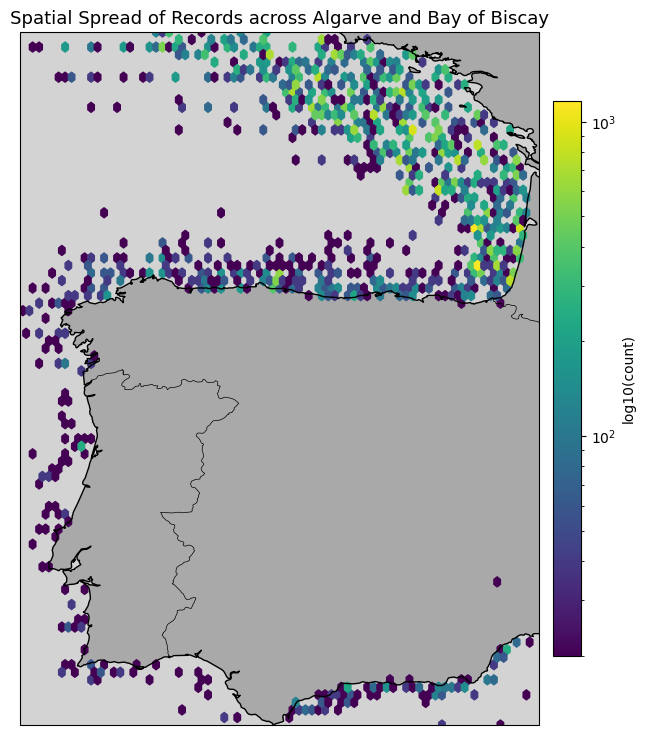

In [3]:
## I'm now sure all my records are in survey area. Time to make a plot to show how they spread across the study region
## First I want to produce a map to show coastlines of the study region to give us a frame of reference. 
## To do this I'll use the max and min lat and longs to generate the map. 

# I specify where to find the lat and longs

lats = df['decimalLatitude'].to_numpy()
lons = df['decimalLongitude'].to_numpy()

# Set the figure size 

plt.figure(figsize=(8, 8))

# Now using cartopy library, make a geographic projection I'm going to call it mymap.

projection = ccrs.PlateCarree()
figure = plt.figure(figsize=(9, 9))
mymap = plt.axes(projection=projection)
mymap.set_extent([min_lon, max_lon, min_lat, max_lat], crs=projection)

# Now I'll be adding in map layers to my map, with monotone colours to not interact with hexbins(later explained)

mymap.coastlines(resolution='10m', linewidth=1)
mymap.add_feature(cfeature.LAND, facecolor='darkgray')
mymap.add_feature(cfeature.OCEAN, facecolor='lightgray')
mymap.add_feature(cfeature.BORDERS, linewidth=0.5)

# Now, loading 95k worth of points by lat and long will produce a mess, so to avoid said mess, 
# I'm going to create hex-bins. these will use a colour module to determine the density of points inside each hexbin, 
# therefore high record density locations will show up as a different colour to sparse record locations. 
# ontop of this I'll include a log function incase of high varability of record density 

hexbins_on_map = mymap.hexbin(
    lons, lats,
    gridsize=80,
    extent=(min_lon, max_lon, min_lat, max_lat),
    bins='log',
    mincnt=1,
    transform=projection
)

# I'll add a colour variant 
colour_bar = figure.colorbar(hexbins_on_map, ax=mymap, shrink=0.8, pad=0.02)
colour_bar.set_label('log10(count)')

# Produce the map 

mymap.set_title('Spatial Spread of Records across Algarve and Bay of Biscay', fontsize=13)
plt.show()

#### Step 3. cont. ####
Temporal distribution of records

To understand the temporal spread of records, I will quickly visualise:
- the number of records collected each year  
- the overall monthly distribution of sampling effort  

This helps identify whether certain years or months were heavily sampled,
which is important context before modelling or comparing regions.

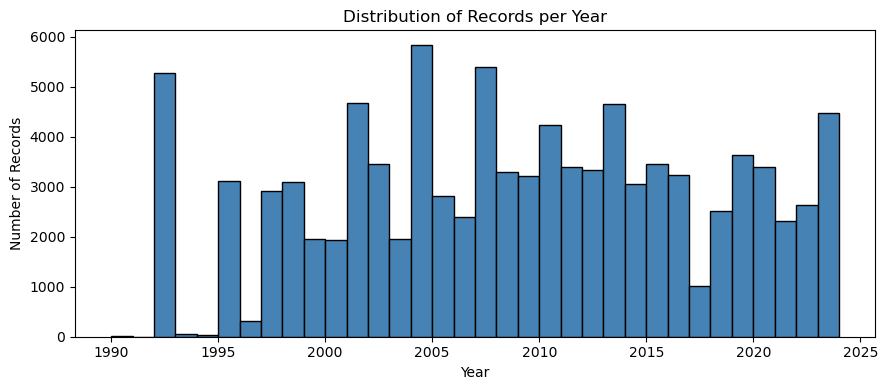

<Figure size 640x480 with 0 Axes>

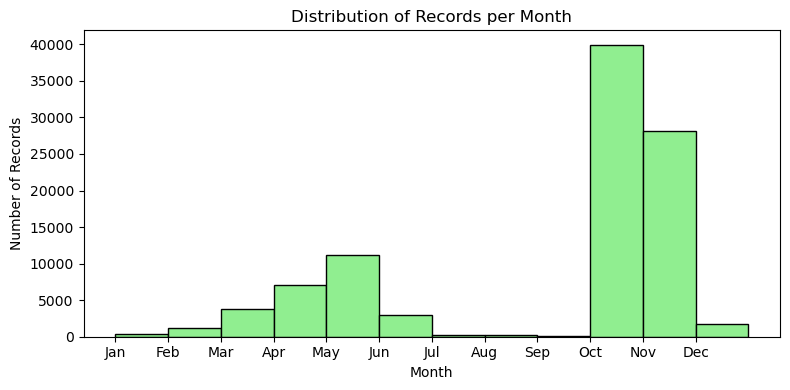

<Figure size 640x480 with 0 Axes>

In [4]:
# Ensure consistent date format (already cleaned earlier)
df['eventDate_dt'] = pd.to_datetime(df['eventDate'], errors='coerce', dayfirst=True)
df['year'] = df['eventDate_dt'].dt.year
df['month'] = df['eventDate_dt'].dt.month

## Now build the histogram for records a year
plt.figure(figsize=(9,4))
plt.hist(df['year'].dropna(), bins=range(int(df['year'].min()), int(df['year'].max())+1), color='steelblue', edgecolor='black')
plt.title('Distribution of Records per Year')
plt.xlabel('Year')
plt.ylabel('Number of Records')
plt.tight_layout()
plt.show()
plt.savefig("figures/yearly_record_distribution.jpeg", dpi=300, bbox_inches="tight")

## Followed by histogram for records per month
plt.figure(figsize=(8,4))
plt.hist(df['month'].dropna(), bins=range(1,14), color='lightgreen', edgecolor='black')
plt.xticks(range(1,13), ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.title('Distribution of Records per Month')
plt.xlabel('Month')
plt.ylabel('Number of Records')
plt.tight_layout()
plt.show()
plt.savefig("figures/annual_record_distribution.jpeg", dpi=300, bbox_inches="tight")

### Discussion: Spatial bias and study area division ####

From the hexbin map I can see that the record density is highly uneven across the study area.  
Most of the sampling effort is concentrated along the French Atlantic coast and the northern Bay of Biscay, while the west-facing coasts of Portugal and southern Spain have far fewer records.  
Any direct comparisons between these regions (for example, trying to see if fish abundance or seasonal patterns differ) would contain artefacts generated by differeneces in sampling effort, by this I mean the differences in record numbers mainly reflect sampling effort rather than true ecological patterns.

To reduce this bias, I’ve decided to split the study area into three distinct coastal regions:
1. **West Iberia** – west-facing coasts of Portugal and Galicia  
2. **South Bay of Biscay** – north-facing coast of northern Spain  
3. **French Atlantic Coast** – northern Bay of Biscay and adjacent shelf

By analysing each region separately, I can account for differences in sampling intensity and make comparisons that are more balanced.  
For future analyses, I’ll standardize the data using metrics like records per sampling event or per grid cell instead of using raw record counts. 
In addition to this, I'm only interested in samples on the Atlantic coastline. Adding in medditereanean records will just increase the noise in the models I produce. To do this I want to remove records east of the Gibraltar Strait. 

Removed 3240 Mediterranean records (east of Gibraltar south of 38.5°N).


<Figure size 800x800 with 0 Axes>

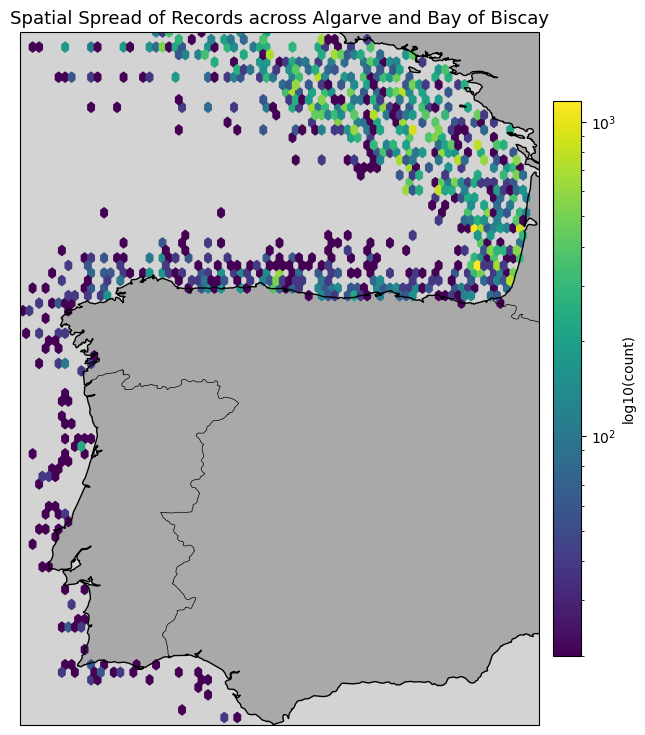

In [5]:
#### Remove mediterranean samples #######

# Gibraltar strait is around -5.3 longitude. I want to apply it only for southern latitudes (Alboran Sea) 
# to prevent loss of bay of biscay records
cut_lon = -5.5
cut_lat = 38.5   

hide_mediterranean = (df['decimalLatitude'] <= cut_lat) & (df['decimalLongitude'] > cut_lon)
before = len(df)
df = df[~hide_mediterranean].copy()
print(f"Removed {before - len(df)} Mediterranean records (east of Gibraltar south of {cut_lat}°N).")

## Now regenerate map with hexbins to be sure, just same code as before

lats = df['decimalLatitude'].to_numpy()
lons = df['decimalLongitude'].to_numpy()
plt.figure(figsize=(8, 8))
projection = ccrs.PlateCarree()
figure = plt.figure(figsize=(9, 9))
mymap = plt.axes(projection=projection)
mymap.set_extent([min_lon, max_lon, min_lat, max_lat], crs=projection)
mymap.coastlines(resolution='10m', linewidth=1)
mymap.add_feature(cfeature.LAND, facecolor='darkgray')
mymap.add_feature(cfeature.OCEAN, facecolor='lightgray')
mymap.add_feature(cfeature.BORDERS, linewidth=0.5)
hexbins_on_map = mymap.hexbin(
    lons, lats,
    gridsize=80,
    extent=(min_lon, max_lon, min_lat, max_lat),
    bins='log',
    mincnt=1,
    transform=projection
)
colour_bar = figure.colorbar(hexbins_on_map, ax=mymap, shrink=0.8, pad=0.02)
colour_bar.set_label('log10(count)')
mymap.set_title('Spatial Spread of Records across Algarve and Bay of Biscay', fontsize=13)
plt.show()
## Happy with that

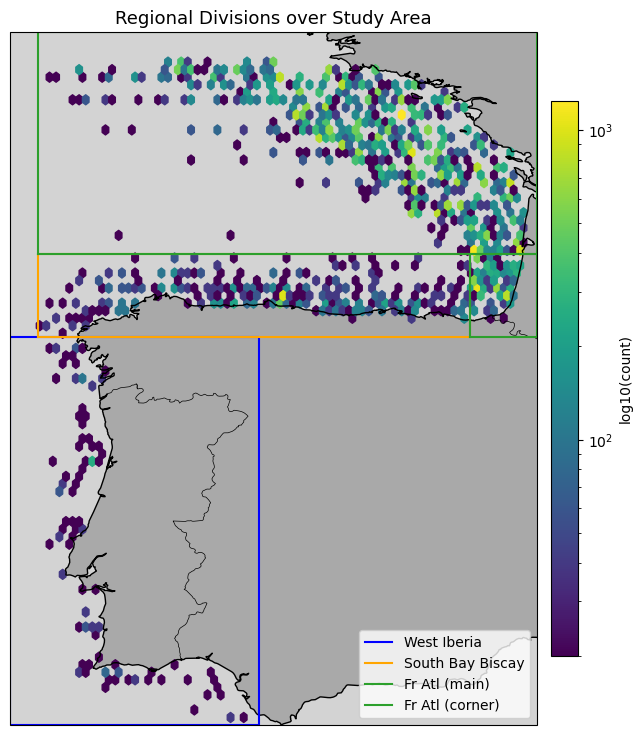

region
fr_atlantic     80380
south_biscay    11220
west_iberia      2420
Name: count, dtype: int64

Records outside all regions: 0


<Figure size 640x480 with 0 Axes>

In [6]:
### Adding a region column to split up dataset into the 3 regions described above.
lat = df['decimalLatitude'].to_numpy()
lon = df['decimalLongitude'].to_numpy()

# I'll assign cooradinates to make boxes the french atlantic is tricky 
# as the bottom corner of the Bay has much similar sampling effort to fren ch atlantic than to south bay. 
# To combat this I'll draw two boxes and both will be assigned French atlantic
# French Atlantic coast (northern Biscay)
fr_atlantic_main = (
    (lat >= 44.5) & (lat <= 48.5) &
    (lon >= -10) & (lon <= -1.0)
)
fr_atlantic_corner = (
    (lat >= 43.0) & (lat < 44.5) &
    (lon >= -2.2) & (lon <= -1.0)
)
fr_atlantic = fr_atlantic_main | fr_atlantic_corner

# South Bay of Biscay (north-facing Spain)
south_biscay = (
    (lat >= 43.0) & (lat < 44.5) &
    (lon >= -10) & (lon <= -2.2)
)

# West Iberia (west-facing Portugal & Galicia)
west_iberia = (
    (lat >= 36.0) & (lat < 43.0) &
    (lon >= -10.5) & (lon <= -6.0)
)

# Assign with numpy.select (order matters only if masks overlap; these don’t)
regions = np.where(fr_atlantic, 'fr_atlantic',
           np.where(south_biscay, 'south_biscay',
           np.where(west_iberia, 'west_iberia', 'outside')))

df['region'] = regions

### Now recreate my prior map and overlay the regions as boxes to see how they fall

projection = ccrs.PlateCarree()
figure = plt.figure(figsize=(9, 9))
mymap = plt.axes(projection=projection)
mymap.set_extent([-10.5, -1.0, 36.0, 48.5], crs=projection)
# basemap 
mymap.coastlines(resolution='10m', linewidth=1)
mymap.add_feature(cfeature.LAND, facecolor='darkgray')
mymap.add_feature(cfeature.OCEAN, facecolor='lightgray')
mymap.add_feature(cfeature.BORDERS, linewidth=0.5)
# hexbin overlay 
hexbins_on_map = mymap.hexbin(
    df['decimalLongitude'], df['decimalLatitude'],
    gridsize=80,
    extent=(-10.5, -1.0, 36.0, 48.5),
    bins='log',
    mincnt=1,
    transform=projection
)
# Colourbar 
colour_bar = figure.colorbar(hexbins_on_map, ax=mymap, shrink=0.8, pad=0.02)
colour_bar.set_label('log10(count)')
# Add in region boxes
regions = {
    'West Iberia':     {'lon': [-10.5, -6.0],  'lat': [36.0, 43.0], 'color': 'blue'},
    'South Bay Biscay':{'lon': [-10, -2.2],   'lat': [43.0, 44.5], 'color': 'orange'},
   'Fr Atl (main)'    : {'lon': (-10,  -1.0), 'lat': (44.5, 48.5), 'color':'tab:green'},
    'Fr Atl (corner)'  : {'lon': (-2.2,  -1.0), 'lat': (43.0, 44.5), 'color':'tab:green'}
}

# draw boxes
for name, box in regions.items():
    lon_min, lon_max = box['lon']
    lat_min, lat_max = box['lat']
    mymap.plot(
        [lon_min, lon_max, lon_max, lon_min, lon_min],
        [lat_min, lat_min, lat_max, lat_max, lat_min],
        color=box['color'], linewidth=1.5, transform=projection, label=name
    )
# --- legend + title ---
mymap.legend(loc='lower right')
mymap.set_title('Regional Divisions over Study Area', fontsize=13)
plt.show()
plt.savefig("figures/spatial_distirbution_of_records_with_region.jpeg", dpi=300, bbox_inches="tight")

# Quick sanity checks
counts = df['region'].value_counts(dropna=False)
print(counts)
print(f"\nRecords outside all regions: {int((df['region'] == 'outside').sum())}")

#### Discussion: Temporal Patterns ####

The annual distribution of records shows continuous sampling effort from 1997 onward. There are records present prior to this year but not annualy, although 1993 was the second most significant year for records. For this reason, I will retain records from 1993 onwards to preserve as much data as possible, while recognising that 1997 marks the start of consistent annual coverage for time series analyses.

Monthly patterns reveal a strong seasonal bias, with very few or no records between July and early October. 
This gap likely reflects survey scheduling rather than ecological patterns, suggesting that many trawl and research programs in the Bay of Biscay and surrounding waters pause during mid-summer. 
Sampling intensity peaks in spring (April–June) and autumn (October–November).

These patterns are important to keep in mind for subsequent analyses, as seasonal or monthly comparisons may primarily reflect variation in sampling effort rather than genuine ecological differences.

In [7]:
# Define cutoff date
After_1993_date = pd.Timestamp('1993-01-01')

# Filter out records before the cutoff
before = len(df)
df = df[df['eventDate_dt'] >= After_1993_date].copy()
after = len(df)

print(f"Removed {before - after} records collected before 01-Jan-1993.")
print(f"{after} records remain in the dataset.")

Removed 5300 records collected before 01-Jan-1993.
88720 records remain in the dataset.


#### Step 4. Inspecting the study size for recorded traits #### 

Now, I want to understand how many records possess information on family, sex and life stage of fish. 
This will help me determine if each charactersitic possesses a study size large enough to make valid comparison/investigations.

In [8]:
# I can check the total records for each key biological variable, 
# by making a dataframe that will give me both total number of records and its percentage 

total_records = len(df)

variables = {
    'Family': df['family'].notna().sum(),
    'Sex': df['sex'].notna().sum(),
    'LifeStage': df['lifeStage'].notna().sum()
}

# My table will be called variable_availability

variable_availability = (
    pd.DataFrame.from_dict(variables, orient='index', columns=['Records_with_data'])
    .assign(Records_total=total_records)
)

# Add percentage coverage
variable_availability['Percent_with_data'] = (variable_availability['Records_with_data'] / total_records * 100).round(2)

display(variable_availability)

,Records_with_data,Records_total,Percent_with_data
Family,88460,88720,99.71
Sex,60,88720,0.07
LifeStage,60,88720,0.07


Following the variable availability table, I now know only to proceed with Family level investigations. 

In [9]:
## Have a quick look at our dataset
df.head

## Save the new dataset to a csv##
df.to_csv("data/data_interim/obis_fish_regions.csv", index = False)